<a href="https://colab.research.google.com/github/Tamar-m/DeepLearningClass/blob/main/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code adapted from: https://github.com/ahmetumutdurmus/zaremba/blob/master/main.py

See also relevant paper: https://arxiv.org/pdf/1409.2329.pdf)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import json
import numpy as np
from google.colab import drive
drive.mount('Google_drive')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

Mounted at Google_drive


In [2]:
# data must be google drive in following path: /Deep Learning Class/Ex2Data
def data_load():
    with open("/content/Google_drive/MyDrive/Deep Learning Class/Ex2Data/ptb.train.txt") as f:
        file = f.read()
        trn = file[1:].split(' ')
    with open("/content/Google_drive/MyDrive/Deep Learning Class/Ex2Data/ptb.valid.txt") as f:
        file = f.read()
        vld = file[1:].split(' ')
    with open("/content/Google_drive/MyDrive/Deep Learning Class/Ex2Data/ptb.test.txt") as f:
        file = f.read()
        tst = file[1:].split(' ')
    words = sorted(set(trn))
    char2ind = {c: i for i, c in enumerate(words)}
    trn = [char2ind[c] for c in trn]
    vld = [char2ind[c] for c in vld]
    tst = [char2ind[c] for c in tst]
    return np.array(trn).reshape(-1, 1), np.array(vld).reshape(-1, 1), np.array(tst).reshape(-1, 1), len(words)

#create minibatches of the data
def minibatch(data, batch_size, seq_length):
    data = torch.tensor(data, dtype = torch.int64)
    num_batches = data.size(0)//batch_size
    data = data[:num_batches*batch_size]
    data=data.view(batch_size,-1)
    dataset = []
    for i in range(0,data.size(1)-1,seq_length):
        seqlen=int(np.min([seq_length,data.size(1)-1-i]))
        if seqlen<data.size(1)-1-i:
            x=data[:,i:i+seqlen].transpose(1, 0)
            y=data[:,i+1:i+seqlen+1].transpose(1, 0)
            dataset.append((x, y))
    return dataset

In [3]:
#Embedding module
class Embed(nn.Module): #embedding is efficient when we have a large number of input features
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.W = nn.Parameter(torch.Tensor(vocab_size, embed_size))

    def forward(self, x):
        return self.W[x]

    def __repr__(self):
        return "Embedding(vocab: {}, embedding: {})".format(self.vocab_size, self.embed_size)

class Linear(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W = nn.Parameter(torch.Tensor(hidden_size, input_size))
        self.b = nn.Parameter(torch.Tensor(hidden_size))

    def forward(self, x):
        z = torch.addmm(self.b, x.view(-1, x.size(2)), self.W.t())
        return z

    def __repr__(self):
        return "FC(input: {}, output: {})".format(self.input_size, self.hidden_size)

class Model(nn.Module):
    def __init__(self, vocab_size, hidden_size, layer_num, dropout, winit, base):
        super().__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.layer_num = layer_num
        self.winit = winit
        self.embed = Embed(vocab_size, hidden_size)
        if base == 'gru':
          self.rnns = [nn.GRU(hidden_size, hidden_size) for i in range(layer_num)] #two GRU layers with 200 units per layer
        else:
          self.rnns = [nn.LSTM(hidden_size, hidden_size) for i in range(layer_num)] #two LSTM layers with 200 units per layer
        self.rnns = nn.ModuleList(self.rnns)
        self.fc = Linear(hidden_size, vocab_size) 
        self.dropout = nn.Dropout(p=dropout)
        self.reset_parameters() #weights are reset uniformly when initializing the model
        
    def reset_parameters(self): #LSTM hidden layers weights initialized uniformly between -0.1 to 0.1
        for param in self.parameters():
            nn.init.uniform_(param, -self.winit, self.winit) 
            
    def state_init(self, batch_size,base): #hidden states are initialized to zero, input of gru is h_0 and input of lstm is (h_0, c_0) 
        dev = next(self.parameters()).device
        if base == 'gru':
          states = [(torch.zeros(1, batch_size, layer.hidden_size, device = dev)) for layer in self.rnns]
        else:
          states = [(torch.zeros(1, batch_size, layer.hidden_size, device = dev), torch.zeros(1, batch_size, layer.hidden_size, device = dev)) for layer in self.rnns]
        return states 

    # detach to complete truncated backpropagation through time (BPTT)
    def detach(self, states, base):
      if base == 'lstm':
        return [(h.detach(), c.detach()) for (h,c) in states] # returns tensors that don't require a gradient
      else:
        return [h.detach() for h in states] #gru layers input of shape h_0

    def forward(self, x, states):
        x = self.embed(x)
        x = self.dropout(x)
        for i, rnn in enumerate(self.rnns):
            x, states[i] = rnn(x, states[i])
            x = self.dropout(x)
        scores = self.fc(x)
        return scores, states

Next we define the loss (negative log likelihood) and perplexity

In [4]:
def nll_loss(scores, y):
    batch_size = y.size(1)
    expscores = scores.exp()
    probabilities = expscores / expscores.sum(1, keepdim = True)
    answerprobs = probabilities[range(len(y.reshape(-1))), y.reshape(-1)]
    return torch.mean(-torch.log(answerprobs) * batch_size)


def perplexity(data,model,base):
  with torch.no_grad():
    losses = []
    states = model.state_init(20,base)
    for x,y in data:
      x, y = x.to(device), y.to(device)
      scores, states = model(x,states)
      loss = nll_loss(scores, y)
      losses.append(loss.data.item()/20)
    return np.exp(np.mean(losses))

In [5]:
def train_one_epoch(data, model, lr, max_norm,base):
    trn, vld, tst = data
    total_words = 0
    states = model.state_init(20,base) # batch size of 20 according to article
    model.train()
    for i, (x, y) in enumerate(trn):
        x, y = x.to(device), y.to(device)
        total_words += x.numel()
        model.zero_grad()
        states = model.detach(states, base)
        scores, states = model(x, states)
        loss = nll_loss(scores, y)
        loss.backward()
        with torch.no_grad():
            norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            for param in model.parameters():
                param -= lr * param.grad
        if i % (len(trn)//10) == 0:
            print("batch no = {:d} / {:d}, ".format(i, len(trn)) +
                  "train loss = {:.3f}, ".format(loss.item()/20) + #calculate loss
                  "lr = {:.3f}, ".format(lr))
    model.eval()
    val_perp = perplexity(vld, model,base)
    print("Validation set perplexity : {:.3f}".format(val_perp))
    print("*************************************************\n")
    return val_perp

In [6]:
def main(data,epochs,epoch_threshold,lr,model,model_name,base,lr_factor):
  train, validation, test, word_len = data_load()
  train = minibatch(train,20,20)
  validation = minibatch(validation, 20, 20)
  test = minibatch(test,20,20)
  output_data = {"model": model_name,
                 "train_perp": [],
                 "test_perp":[],
                 "val_perp":[]
                 }
  best_perp = np.Inf
  for epoch in range(1, epochs + 1):
      if epoch > epoch_threshold: 
        lr = lr / lr_factor # after epoch threshold, learning rate decreased by a factor for each epoch
      print(f'Epoch {epoch}/{epochs}')
      val_perp = train_one_epoch((train,validation,test),model,lr,5,base)   
      model.eval()   
      test_perp = perplexity(test, model,base)
      train_perp = perplexity(train, model,base)
      output_data["train_perp"].append(train_perp)
      output_data["test_perp"].append(test_perp)
      output_data["val_perp"].append(val_perp)
      filename = model_name + '.json'
      if test_perp < best_perp:
        state = {
                'model': model.state_dict(),
                'train_perp': train_perp,
                'test_perp': test_perp,
                'epoch': epoch,
                }
        best_perp = test_perp
        torch.save(state, model_name + '.pt')
        with open(filename, 'w', encoding='utf-8') as f:
          json.dump(output_data, f, indent=4)
      print("Test set perplexity : {:.3f}".format(test_perp))
      print("Training over")



In [7]:
# Running LSTM model without dropout

train, validation, test, words_len = data_load()
train = minibatch(train,20,20)
validation = minibatch(validation, 20, 20)
test = minibatch(test,20,20)

model_lstm = Model(words_len,200,2,0,0.1,'lstm') #LSTM model without dropout
model_lstm.to(device)
num_epochs = 13
lr = 1
epoch_threshold = 4
main((train,validation,test), num_epochs, epoch_threshold, lr,model_lstm,"LSTM",'lstm',2)


Epoch 1/13
batch no = 0 / 2323, train loss = 9.205, lr = 1.000, 
batch no = 232 / 2323, train loss = 6.250, lr = 1.000, 
batch no = 464 / 2323, train loss = 5.965, lr = 1.000, 
batch no = 696 / 2323, train loss = 5.763, lr = 1.000, 
batch no = 928 / 2323, train loss = 5.270, lr = 1.000, 
batch no = 1160 / 2323, train loss = 5.396, lr = 1.000, 
batch no = 1392 / 2323, train loss = 5.499, lr = 1.000, 
batch no = 1624 / 2323, train loss = 5.205, lr = 1.000, 
batch no = 1856 / 2323, train loss = 4.951, lr = 1.000, 
batch no = 2088 / 2323, train loss = 5.496, lr = 1.000, 
batch no = 2320 / 2323, train loss = 5.333, lr = 1.000, 
Validation set perplexity : 180.377
*************************************************

Test set perplexity : 179.237
Training over
Epoch 2/13
batch no = 0 / 2323, train loss = 5.651, lr = 1.000, 
batch no = 232 / 2323, train loss = 5.010, lr = 1.000, 
batch no = 464 / 2323, train loss = 5.039, lr = 1.000, 
batch no = 696 / 2323, train loss = 5.024, lr = 1.000, 
batch

In [8]:
# Running LSTM model with 30% dropout
train, validation, test, words_len = data_load()
model_lstm_dropout = Model(words_len,200,2,0.3,0.1,'lstm') #LSTM model with 30% dropout
model_lstm_dropout.to(device)
num_epochs = 25
lr = 1
lr_factor = 1.5
epoch_threshold = 8
main((train,validation,test), num_epochs, epoch_threshold, lr, model_lstm_dropout,"LSTM_dropout",'lstm',lr_factor)

Epoch 1/25
batch no = 0 / 2323, train loss = 9.212, lr = 1.000, 
batch no = 232 / 2323, train loss = 6.279, lr = 1.000, 
batch no = 464 / 2323, train loss = 6.096, lr = 1.000, 
batch no = 696 / 2323, train loss = 5.861, lr = 1.000, 
batch no = 928 / 2323, train loss = 5.387, lr = 1.000, 
batch no = 1160 / 2323, train loss = 5.538, lr = 1.000, 
batch no = 1392 / 2323, train loss = 5.659, lr = 1.000, 
batch no = 1624 / 2323, train loss = 5.337, lr = 1.000, 
batch no = 1856 / 2323, train loss = 5.099, lr = 1.000, 
batch no = 2088 / 2323, train loss = 5.667, lr = 1.000, 
batch no = 2320 / 2323, train loss = 5.545, lr = 1.000, 
Validation set perplexity : 199.772
*************************************************

Test set perplexity : 198.043
Training over
Epoch 2/25
batch no = 0 / 2323, train loss = 5.872, lr = 1.000, 
batch no = 232 / 2323, train loss = 5.280, lr = 1.000, 
batch no = 464 / 2323, train loss = 5.252, lr = 1.000, 
batch no = 696 / 2323, train loss = 5.205, lr = 1.000, 
batch

In [16]:
# Running GRU model without dropout

model_gru = Model(words_len,200,2,0,0.1,'gru') #GRU model no dropout
model_gru.to(device)
num_epochs = 20
lr = 0.4
epoch_threshold = 4
lr_factor = 1.9
main((train,validation,test), num_epochs, epoch_threshold, lr, model_gru, "GRU",'gru',lr_factor)

Epoch 1/20
batch no = 0 / 2323, train loss = 9.197, lr = 0.400, 
batch no = 232 / 2323, train loss = 6.347, lr = 0.400, 
batch no = 464 / 2323, train loss = 5.968, lr = 0.400, 
batch no = 696 / 2323, train loss = 5.810, lr = 0.400, 
batch no = 928 / 2323, train loss = 5.312, lr = 0.400, 
batch no = 1160 / 2323, train loss = 5.439, lr = 0.400, 
batch no = 1392 / 2323, train loss = 5.563, lr = 0.400, 
batch no = 1624 / 2323, train loss = 5.245, lr = 0.400, 
batch no = 1856 / 2323, train loss = 5.004, lr = 0.400, 
batch no = 2088 / 2323, train loss = 5.520, lr = 0.400, 
batch no = 2320 / 2323, train loss = 5.389, lr = 0.400, 
Validation set perplexity : 198.479
*************************************************

Test set perplexity : 197.338
Training over
Epoch 2/20
batch no = 0 / 2323, train loss = 5.855, lr = 0.400, 
batch no = 232 / 2323, train loss = 5.076, lr = 0.400, 
batch no = 464 / 2323, train loss = 5.052, lr = 0.400, 
batch no = 696 / 2323, train loss = 5.067, lr = 0.400, 
batch

In [10]:
model_gru_dropout = Model(words_len,200,2,0.4,0.1,'gru') #GRU model 40% dropout
model_gru_dropout.to(device)
num_epochs = 50
lr = 0.5
lr_factor = 1.2
epoch_threshold = 15
main((train,validation,test), num_epochs, epoch_threshold, lr, model_gru_dropout,"GRU_dropout",'gru',lr_factor)

Epoch 1/50
batch no = 0 / 2323, train loss = 9.210, lr = 0.500, 
batch no = 232 / 2323, train loss = 6.483, lr = 0.500, 
batch no = 464 / 2323, train loss = 6.123, lr = 0.500, 
batch no = 696 / 2323, train loss = 6.018, lr = 0.500, 
batch no = 928 / 2323, train loss = 5.564, lr = 0.500, 
batch no = 1160 / 2323, train loss = 5.712, lr = 0.500, 
batch no = 1392 / 2323, train loss = 5.789, lr = 0.500, 
batch no = 1624 / 2323, train loss = 5.466, lr = 0.500, 
batch no = 1856 / 2323, train loss = 5.261, lr = 0.500, 
batch no = 2088 / 2323, train loss = 5.836, lr = 0.500, 
batch no = 2320 / 2323, train loss = 5.711, lr = 0.500, 
Validation set perplexity : 224.496
*************************************************

Test set perplexity : 221.674
Training over
Epoch 2/50
batch no = 0 / 2323, train loss = 5.968, lr = 0.500, 
batch no = 232 / 2323, train loss = 5.471, lr = 0.500, 
batch no = 464 / 2323, train loss = 5.420, lr = 0.500, 
batch no = 696 / 2323, train loss = 5.456, lr = 0.500, 
batch

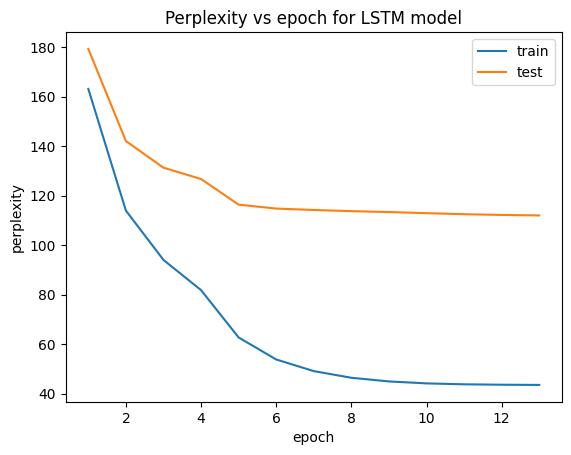

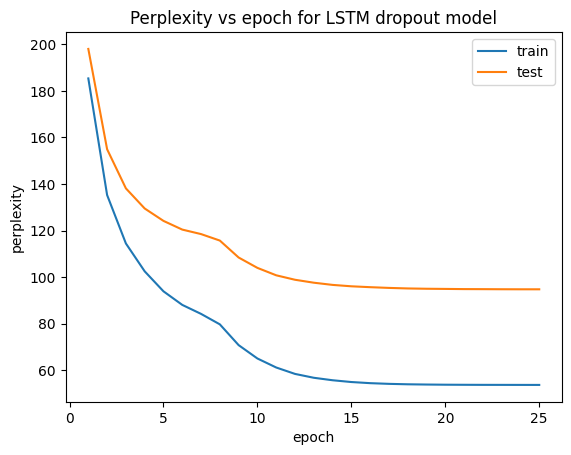

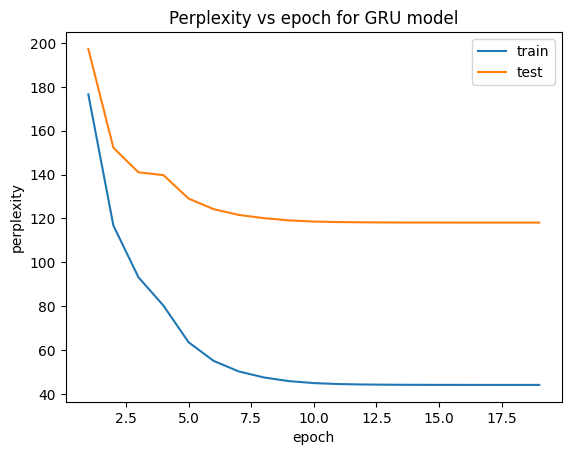

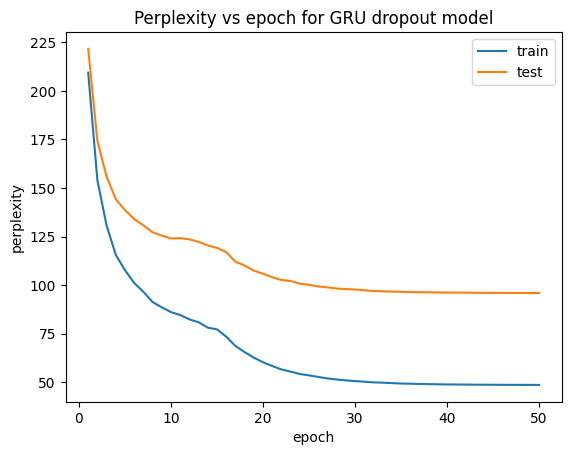

In [17]:
#plot perplexity vs epoch of test and train data from json files
summary = {'LSTM Model' : [],
           'LSTM Dropout Model': [],
           'GRU Model': [],
           'GRU Dropout Model':[]}
with open('LSTM.json', mode='r', encoding='utf-8') as json_f:
    results_dict = json.load(json_f)
accuracies_regular_model = plt.figure()
plt.plot(range(1, len(results_dict['train_perp']) + 1),
             results_dict['train_perp'])
plt.plot(range(1, len(results_dict['test_perp']) + 1),
             results_dict['test_perp'])
plt.legend(['train','test'])
plt.title('Perplexity vs epoch for LSTM model')
plt.xlabel('epoch')
plt.ylabel('perplexity')
accuracies_regular_model.savefig('LSTM_perplexity_plot.png')
plt.show()
summary['LSTM Model'].append(min(results_dict['train_perp']))
summary['LSTM Model'].append(min(results_dict['test_perp']))
summary['LSTM Model'].append(min(results_dict['val_perp']))

with open('LSTM_dropout.json', mode='r', encoding='utf-8') as json_f:
    results_dict = json.load(json_f)
accuracies_dropout_model = plt.figure()
plt.plot(range(1, len(results_dict['train_perp']) + 1),
             results_dict['train_perp'])
plt.plot(range(1, len(results_dict['test_perp']) + 1),
             results_dict['test_perp'])
plt.legend(['train','test'])
plt.title('Perplexity vs epoch for LSTM dropout model')
plt.xlabel('epoch')
plt.ylabel('perplexity')
accuracies_dropout_model.savefig('LSTM_dropout_perplexity_plot.png')
plt.show()
summary['LSTM Dropout Model'].append(min(results_dict['train_perp']))
summary['LSTM Dropout Model'].append(min(results_dict['test_perp']))
summary['LSTM Dropout Model'].append(min(results_dict['val_perp']))

with open('GRU.json', mode='r', encoding='utf-8') as json_f:
    results_dict = json.load(json_f)
accuracies_wd_model = plt.figure()
plt.plot(range(1, len(results_dict['train_perp']) + 1),
             results_dict['train_perp'])
plt.plot(range(1, len(results_dict['test_perp']) + 1),
             results_dict['test_perp'])
plt.legend(['train','test'])
plt.title('Perplexity vs epoch for GRU model')
plt.xlabel('epoch')
plt.ylabel('perplexity')
accuracies_wd_model.savefig('GRU_perplexity_plot.png')
plt.show()
summary['GRU Model'].append(min(results_dict['train_perp']))
summary['GRU Model'].append(min(results_dict['test_perp']))
summary['GRU Model'].append(min(results_dict['val_perp']))

with open('GRU_dropout.json', mode='r', encoding='utf-8') as json_f:
    results_dict = json.load(json_f)
accuracies_bn_model = plt.figure()
plt.plot(range(1, len(results_dict['train_perp']) + 1),
             results_dict['train_perp'])
plt.plot(range(1, len(results_dict['test_perp']) + 1),
             results_dict['test_perp'])
plt.legend(['train','test'])
plt.title('Perplexity vs epoch for GRU dropout model')
plt.xlabel('epoch')
plt.ylabel('perplexity')
accuracies_bn_model.savefig('GRU_dropout_perplexity_plot.png')
plt.show()
summary['GRU Dropout Model'].append(min(results_dict['train_perp']))
summary['GRU Dropout Model'].append(min(results_dict['test_perp']))
summary['GRU Dropout Model'].append(min(results_dict['val_perp']))

In [18]:
print("{:<20} {:<20} {:<20} {:<20}".format('MODEL', 'VALIDATION', 'TRAIN', 'TEST'))
 
#print max train and test accuracy for each model, summarize in a table
for key, value in summary.items():
    train,test,val = value
    print("{:<20} {:<20} {:<20} {:<20}".format(key, val, train, test))

MODEL                VALIDATION           TRAIN                TEST                
LSTM Model           116.81793472388085   43.56383939463198    112.00484327485898  
LSTM Dropout Model   98.685837708338      53.661494146399185   94.74924309210856   
GRU Model            123.65906868347274   44.084560623608255   118.12309532214924  
GRU Dropout Model    99.61510675625789    48.53479991361488    95.86603316534722   
